In [185]:
# generally useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as  sc

import geopandas as gpd
from matplotlib.collections import PatchCollection

# For interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [186]:
livestock = pd.read_csv('data/Production_Livestock_E_All_Data_(Normalized).csv', encoding='iso-8859-1')
beehives = livestock.loc[livestock['Item'] == 'Beehives', ['Area', 'Value', 'Year']]
beehives.columns = ['Area', 'Beehives', 'Year']
beehives.reset_index(drop=True, inplace=True)
beehives.head()

,Area,Beehives,Year
0,Albania,95100.0,1961
1,Albania,92800.0,1962
2,Albania,83500.0,1963
3,Albania,96500.0,1964
4,Albania,109800.0,1965


In [210]:
beehives['Year'] = pd.to_datetime(beehives['Year'], format="%Y")
bw = beehives[beehives['Area'] == 'Europe']
bw = bw.reset_index();

In [211]:
bw = bw.drop(['Area', 'index'], axis='columns')

In [212]:
bw = bw.set_index(['Year'])

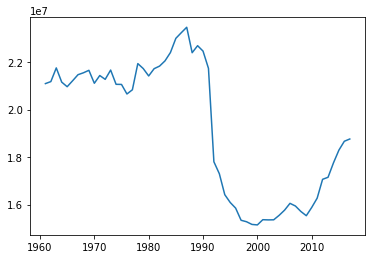

In [213]:
plt.plot(bw)

In [214]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(8).mean()
    rolstd = timeseries.rolling(8).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test")
    dftest = adfuller(timeseries.Beehives.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

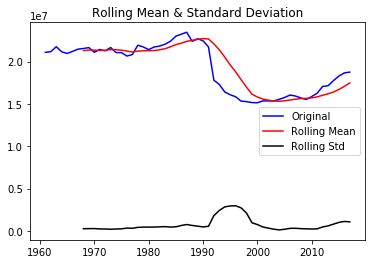

Results of Dickey-Fuller Test
Test Statistic                 -1.527749
p-value                         0.519742
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [215]:
test_stationarity(bw)

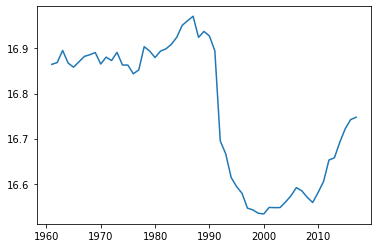

In [216]:
bw_log = np.log(bw)
plt.plot(bw_log)

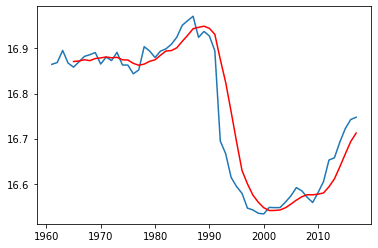

In [217]:
moving_avg = bw_log.rolling(5).mean()
plt.plot(bw_log)
plt.plot(moving_avg, color='red')

In [218]:
bw_log_moving_avg_diff = bw_log - moving_avg
bw_log_moving_avg_diff.dropna(inplace=True)
bw_log_moving_avg_diff.head(12)

,Beehives
Year,
1965-01-01,-0.012541
1966-01-01,-0.001841
1967-01-01,0.007479
1968-01-01,0.013113
1969-01-01,0.013274
1970-01-01,-0.013623
1971-01-01,-0.000369
1972-01-01,-0.006083
1973-01-01,0.011081


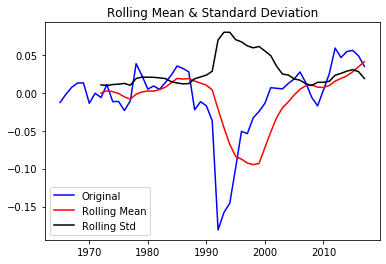

Results of Dickey-Fuller Test
Test Statistic                 -2.004071
p-value                         0.284791
#Lags Used                      0.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [219]:
test_stationarity(bw_log_moving_avg_diff)

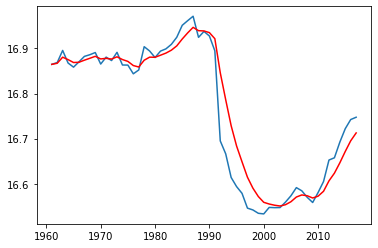

In [220]:
expweightend_avg = bw_log.ewm(span=5).mean()
plt.plot(bw_log)
plt.plot(expweightend_avg, color='red')

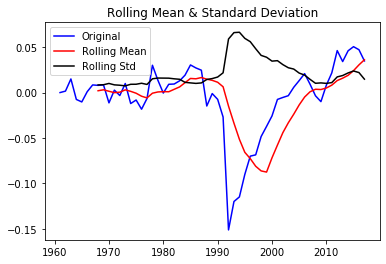

Results of Dickey-Fuller Test
Test Statistic                 -1.985714
p-value                         0.292872
#Lags Used                      0.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


In [221]:
bw_log_ewma_diff = bw_log - expweightend_avg
test_stationarity(bw_log_ewma_diff)

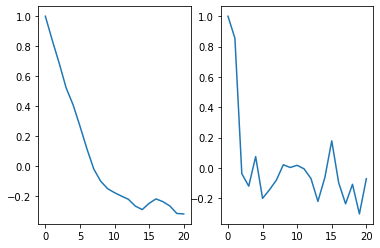

In [222]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(bw_log_ewma_diff, nlags=20)
lag_pacf = pacf(bw_log_ewma_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)

plt.subplot(122)
plt.plot(lag_pacf)

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


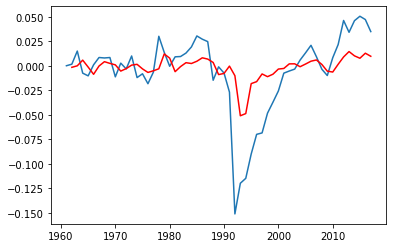

In [223]:
model = ARIMA(bw_log, order = (2,1,0))
results_AR = model.fit(dip=-1)
plt.plot(bw_log_ewma_diff)
plt.plot(results_AR.fittedvalues, color='red')

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


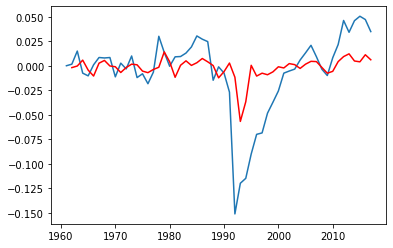

In [224]:
model = ARIMA(bw_log, order=(0,1,2))
resultsMA = model.fit(disp=-1)
plt.plot(bw_log_ewma_diff)
plt.plot(resultsMA.fittedvalues, color='red')

In [225]:
predictions_ARIMA_diff = pd.Series(resultsMA.fittedvalues, copy=True)

In [226]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [227]:
predictions_ARIMA_diff_cumsum_log = pd.Series(bw_log.loc['1961-01-01'].Beehives, index = bw_log.index)
predictions_ARIMA_diff_cumsum_log = predictions_ARIMA_diff_cumsum_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

In [228]:
predictions_ARIMA_diff_cumsum_log.head()

Year
1961-01-01    16.864671
1962-01-01    16.862772
1963-01-01    16.862495
1964-01-01    16.868220
1965-01-01    16.863782
dtype: float64

In [229]:
predictions_ARIMA = np.exp(predictions_ARIMA_diff_cumsum_log)

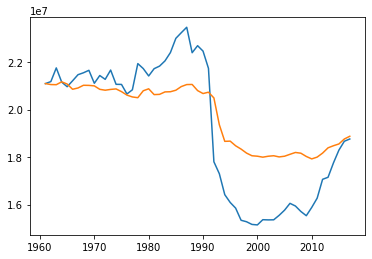

In [230]:
plt.plot(bw)
plt.plot(predictions_ARIMA)

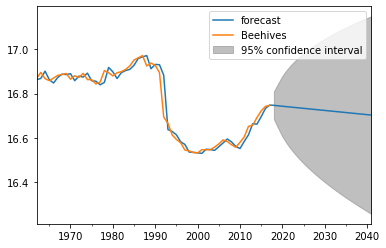

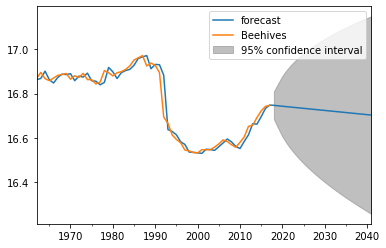

In [231]:
resultsMA.plot_predict(1,80)

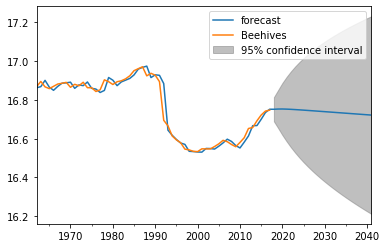

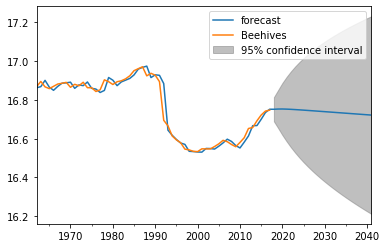

In [232]:
results_AR.plot_predict(1,80)

## New try

In [81]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [82]:
bw

,Beehives
Year,
1961-01-01,49173473.0
1962-01-01,49639027.0
1963-01-01,49970283.0
1964-01-01,49625534.0
1965-01-01,50368109.0
1966-01-01,52083386.0
1967-01-01,52288194.0
1968-01-01,52573800.0
1969-01-01,53478677.0


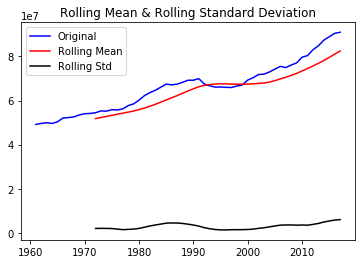

In [83]:
rolling_mean = bw.rolling(window = 12).mean()
rolling_std = bw.rolling(window = 12).std()
plt.plot(bw, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As you can see, the rolling mean and rolling standard deviation increase with time. Therefore, we can conclude that the time series is not stationary.

In [84]:
result = adfuller(bw['Beehives'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.3614260865455343
p-value: 0.9799936702740074
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

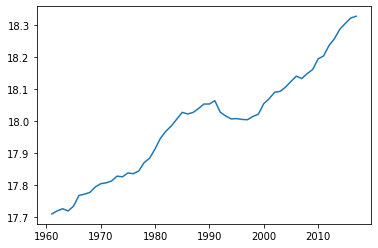

In [85]:
bw_log = np.log(bw)
plt.plot(bw_log)

Let’s create a function to run the two tests which determine whether a given time series is stationary.

In [86]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Beehives'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

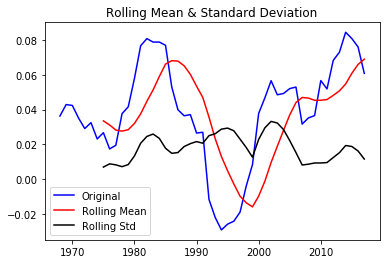

ADF Statistic: -2.946783572766816
p-value: 0.04017193408588419
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064


In [87]:
rolling_mean = bw_log.rolling(window=8).mean()
bw_log_minus_mean = bw_log - rolling_mean
bw_log_minus_mean.dropna(inplace=True)
get_stationarity(bw_log_minus_mean)

As we can see, after subtracting the mean, the rolling mean and standard deviation are approximately horizontal. The p-value is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Therefore, the time series is stationary.

Applying exponential decay is another way of transforming a time series such that it is stationary.

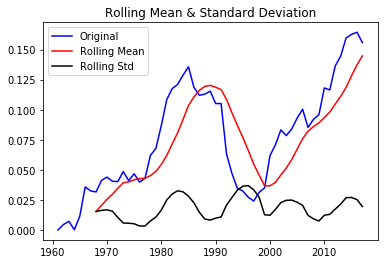

ADF Statistic: -1.8162591606436527
p-value: 0.3724198708117765
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


In [88]:
rolling_mean_exp_decay = bw_log.ewm(halflife=8, min_periods=0, adjust=True).mean()
bw_log_exp_decay = bw_log - rolling_mean_exp_decay
bw_log_exp_decay.dropna(inplace=True)
get_stationarity(bw_log_exp_decay)

Exponential decay performed worse than subtracting the rolling mean. However, it is still more stationary than the original.

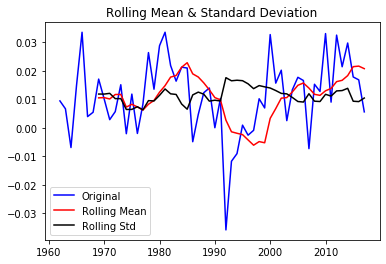

ADF Statistic: -3.2106574590034906
p-value: 0.01937601244072977
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


In [89]:
bw_log_shift = bw_log - bw_log.shift()
bw_log_shift.dropna(inplace=True)
get_stationarity(bw_log_shift)

Time shifting performed worse than subtracting the rolling mean. However, it is still more stationary than the original.

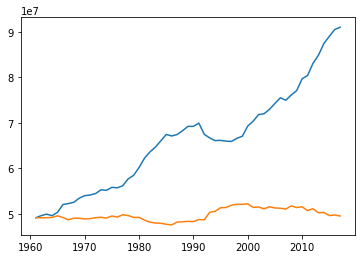

In [90]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(bw_log['Beehives'].iloc[0], index=bw_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(bw)
plt.plot(predictions_ARIMA)

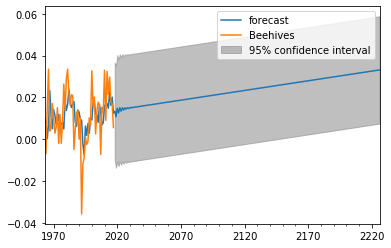

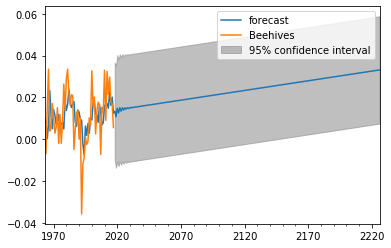

In [121]:
results.plot_predict(1,264)